# LiDAR Intensity Harmonization
Intensity is a relative measurement and is often different between flights. This notebook demonstrates a simple method for harmonizing different scans.

In [1]:
# Run the below to generate the data
# ! las2las -i lidar_test/N096E372.laz -otxt -keep_random_fraction .05 -oparse xyztri -stdout > lidar_test/lidar.txt
# ! head lidar.txt

In [2]:
import pptk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [7, 7]


(588332, 6)


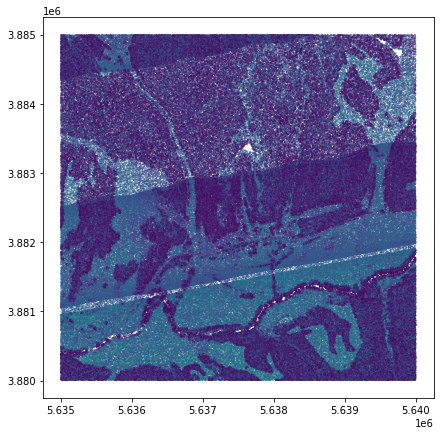

In [3]:
# Show data
data = np.loadtxt("lidar_test/lidar.txt")
plt.scatter(
    data[:, 0], 
    data[:, 1], 
    s=0.05, 
    c=data[:, 5], 
    vmin=0, 
    vmax=255)
print(data.shape)

In [4]:
attr1 = data[:, 3] #time
attr2 = data[:, 4] #r (?)
attr3 = data[:, 5] # intensity
# v = pptk.viewer(data[:, :3])
# v.attributes(attr1, attr2 ,attr3)

## Separate points into individual scans
Consecutive laser points on a flight are very close in time.
Sort by time and pick points where there is more than a 1 second gap, then label each point by the segment it belongs to.

In [5]:
# Figure out which points belong to different scans
# based on the time of recording

sorted_time_indices = np.argsort(attr1)
sorted_time = np.sort(attr1)

# get differences between timestamps
time_diff = np.diff(sorted_time)

curr_id = 0
flight_ids_sorted = [curr_id] # get the first point
for idx in range(len(attr1)-1):
    if time_diff[idx] > 1:
        curr_id += 1
    flight_ids_sorted.append(curr_id)

flight_ids = [None]*len(sorted_time_indices)
for i in range(len(sorted_time_indices)):
    flight_ids[sorted_time_indices[i]] = flight_ids_sorted[i] 
    
flight_ids = np.array(flight_ids)
print(flight_ids.shape)

(588332,)


In [6]:
# Filter extreme intensities- is this necessary?
bad_colors = np.argwhere((attr3 < 3) | (attr3 > 252))
print(bad_colors.shape)

data = np.delete(data, bad_colors, axis=0)
flight_ids = np.delete(flight_ids, bad_colors, axis=0)

(5405, 1)


In [7]:
print(data.shape)
print(flight_ids.shape)

(582927, 6)
(582927,)


In [8]:
ids = np.unique(flight_ids)
print(ids)

[0 1 2 3]


## Build Fixes Matrix
The code below generates a matrix, with each cell representing a linear transformation between scan intensities. We first search for overlap regions using kdtrees, and generate discrete pairs that are close together. Assuming we are able to find enough points between two scans, we then solve for this transformation using least squares method on these pairs. 

In [9]:
fixes = np.zeros((ids.size, ids.size))
for i in ids:
    for j in ids:
        if i > j:
            # only do forward pairs
            continue
        if i == j:
            fixes[i, j] = 1
            fixes[j, i] = 1
            continue
        print(f"Processing pairs: ({i}, {j})")
        # create a set of pairs between i and j 
        # that are close together
        
        A = []
        B = []
        
        dataA = data[np.where(flight_ids==i)].squeeze()
        dataB = data[np.where(flight_ids==j)].squeeze()
#         v2=pptk.viewer(dataA[:, :3])
#         v2.attributes(dataA[:, 5])
#         v3=pptk.viewer(dataB[:, :3])
#         v3.attributes(dataB[:, 5])
#         input()
        kd = pptk.kdtree._build(dataB[:, :3])
        query = pptk.kdtree._query(kd, dataA[:, :3], dmax=2)

        for idx, q in enumerate(query):
            if len(q) > 0:
                A.append(idx)
                B.append(q[0])
        
        A = np.array(A)
        B = np.array(B)
        print(f"Foud overlap: {A.size} points")
        # print(B.size)
        if A.size > 10:
            # Found enough pairs
            print(dataA[A].shape)
            print(dataB[B].shape)
            
            i_to_j = np.linalg.lstsq(
                np.expand_dims(dataA[A][:, 5], 1),
                dataB[B][:, 5], 
                rcond=None)
            j_to_i = np.linalg.lstsq(
                np.expand_dims(dataB[B][:, 5], 1),
                dataA[A][:, 5], 
                rcond=None)
        
            fixes[i, j] = i_to_j[0][0]
            fixes[j, i] = j_to_i[0][0]

        print("")
    

Processing pairs: (0, 1)
Foud overlap: 0 points

Processing pairs: (0, 2)
Foud overlap: 0 points

Processing pairs: (0, 3)
Foud overlap: 8043 points
(8043, 6)
(8043, 6)

Processing pairs: (1, 2)
Foud overlap: 1679 points
(1679, 6)
(1679, 6)

Processing pairs: (1, 3)
Foud overlap: 0 points

Processing pairs: (2, 3)
Foud overlap: 8429 points
(8429, 6)
(8429, 6)



In [10]:
print("fixes matrix:")
print(fixes)


fixes matrix:
[[1.         0.         0.         0.59357246]
 [0.         1.         1.0526177  0.        ]
 [0.         0.79211531 1.         0.99165639]
 [1.5885751  0.         0.92478124 1.        ]]


## Apply the Fix
Now we just need to apply the transformation to each point

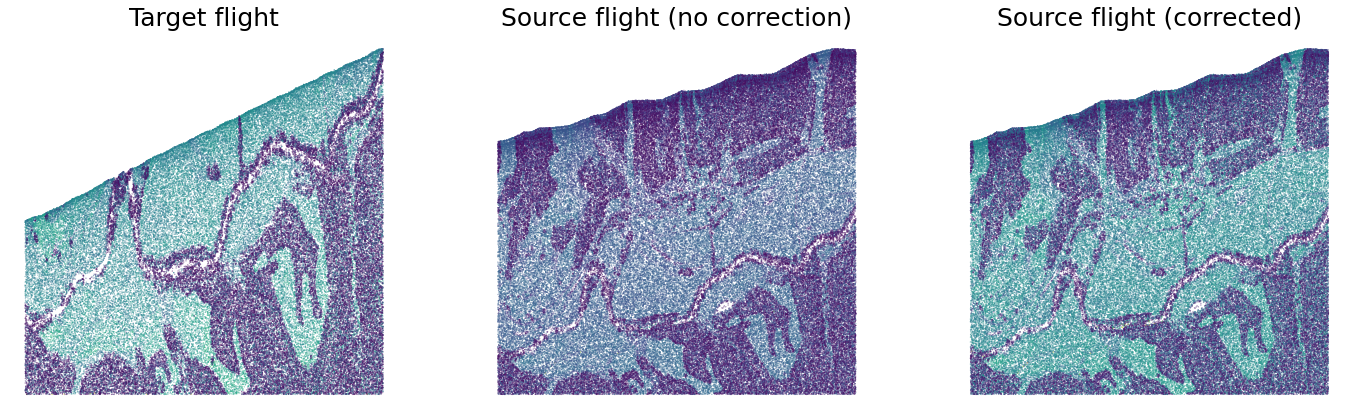

In [11]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [24, 7]
import matplotlib.pyplot as plt

target_id = 0
source_id = 3

source_data = data[np.where(flight_ids==source_id)].copy()
target_data = data[np.where(flight_ids==target_id)].copy()

source_intensities = source_data[:, 5].copy()
target_intensities = target_data[:, 5].copy()
fixed = source_intensities.copy()
fixed *= fixes[source_id, target_id]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.scatter(
    target_data[:, 0], 
    target_data[:, 1], 
    s=0.05, 
    c=target_intensities, 
    vmin=0, 
    vmax=255)
    
ax1.axis('off')
ax1.set_title("Target flight", fontdict={"fontsize": 25})

ax2.scatter(
    source_data[:, 0], 
    source_data[:, 1], 
    s=0.05, 
    c=source_intensities, 
    vmin=0, 
    vmax=255)

ax2.axis('off')
ax2.set_title("Source flight (no correction)", fontdict={"fontsize": 25})

ax3.scatter(
    source_data[:, 0],
    source_data[:, 1],
    s=0.05,
    c=fixed,
    vmin=0,
    vmax=255)
ax3.axis('off')
ax3.set_title("Source flight (corrected)", fontdict={"fontsize": 25})
plt.show()


### Chaining Transformations
Since we were only able to build transformations for neighboring tiles, we will have to chain transformations together to transform non-neighboring tiles. This can be thought of as a graph problem, where we are searching for a path between two nodes.

In [12]:
# need to fill the holes in on the fix matrix
fixes_c = fixes.copy()
print("Original")
print(fixes)

not_complete = np.argwhere(fixes_c == 0)
complete = np.argwhere((fixes_c > 0) & (fixes_c != 1))
# print(not_complete)
# print(complete)

# There is a way to do this automatically. Note that the outer dimension must match
# the inner dimension when chaining, and that the final dimension is the desired 
# target dimension
fixes_c[0, 1] = fixes_c[0, 3]*fixes_c[3, 2]*fixes_c[2, 1]
fixes_c[1, 0] = fixes_c[1, 2]*fixes_c[2, 3]*fixes_c[3, 0]

fixes_c[0, 2] = fixes_c[0, 3]*fixes_c[3, 2]
fixes_c[2, 0] = fixes_c[2, 3]*fixes_c[3, 0]

fixes_c[1, 3] = fixes_c[1, 2]*fixes_c[2, 3]
fixes_c[3, 1] = fixes_c[3, 2]*fixes_c[2, 1]

print("\nComplete")
print(fixes_c)  

Original
[[1.         0.         0.         0.59357246]
 [0.         1.         1.0526177  0.        ]
 [0.         0.79211531 1.         0.99165639]
 [1.5885751  0.         0.92478124 1.        ]]

Complete
[[1.         0.43481163 0.54892467 0.59357246]
 [1.6582104  1.         1.0526177  1.04383508]
 [1.57532065 0.79211531 1.         0.99165639]
 [1.5885751  0.73253337 0.92478124 1.        ]]


### Fixing the entire tile

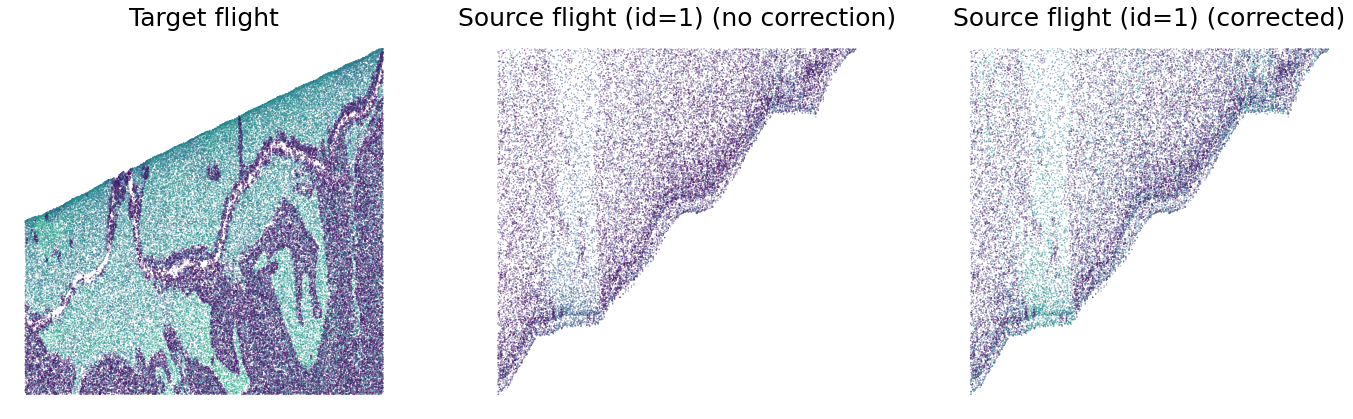

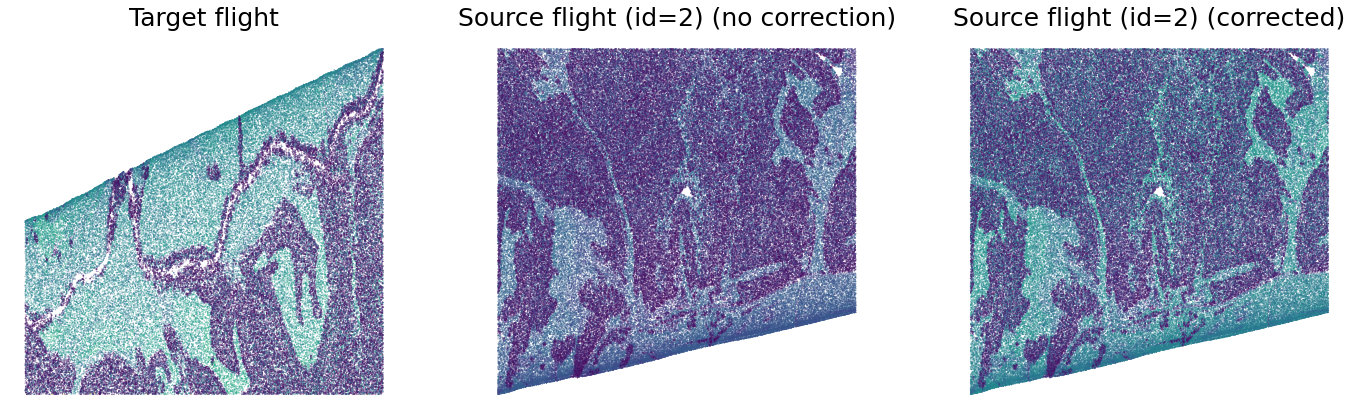

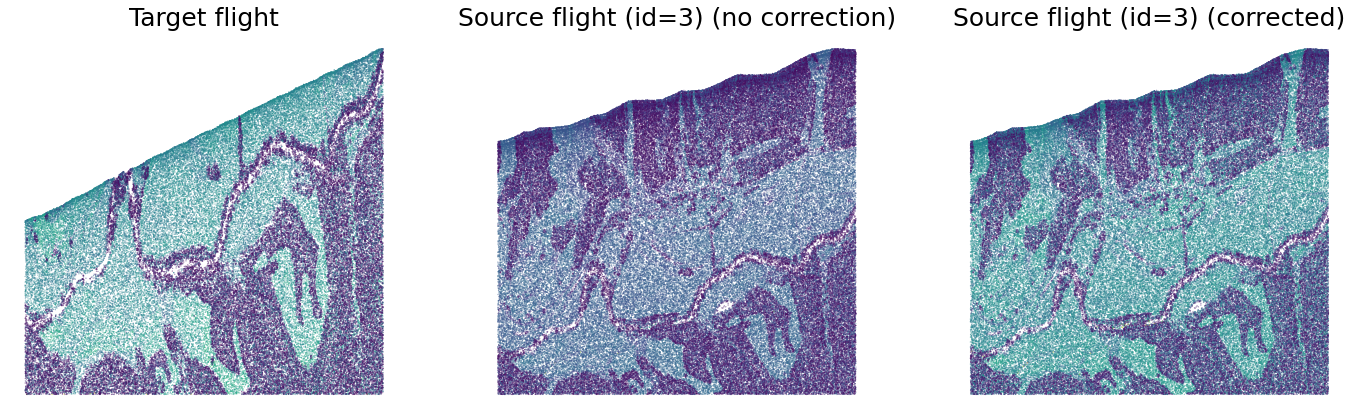

In [13]:
target_id = 0

for source_id in range(1, 4):
    source_data = data[np.where(flight_ids==source_id)].copy()
    target_data = data[np.where(flight_ids==target_id)].copy()

    source_intensities = source_data[:, 5].copy()
    target_intensities = target_data[:, 5].copy()
    fixed = source_intensities.copy()
    fixed *= fixes_c[source_id, target_id]
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    ax1.scatter(
        target_data[:, 0], 
        target_data[:, 1], 
        s=0.05, 
        c=target_intensities, 
        vmin=0, 
        vmax=255)

    ax1.axis('off')
    ax1.set_title("Target flight", fontdict={"fontsize": 25})

    ax2.scatter(
        source_data[:, 0], 
        source_data[:, 1], 
        s=0.05, 
        c=source_intensities, 
        vmin=0, 
        vmax=255)

    ax2.axis('off')
    ax2.set_title(f"Source flight (id={source_id}) (no correction)", fontdict={"fontsize": 25})

    ax3.scatter(
        source_data[:, 0],
        source_data[:, 1],
        s=0.05,
        c=fixed,
        vmin=0,
        vmax=255)
    ax3.axis('off')
    ax3.set_title(f"Source flight (id={source_id}) (corrected)", fontdict={"fontsize": 25})

    plt.show()
    

### Putting it all together

(28699, 6)
(243772, 6)
(193198, 6)


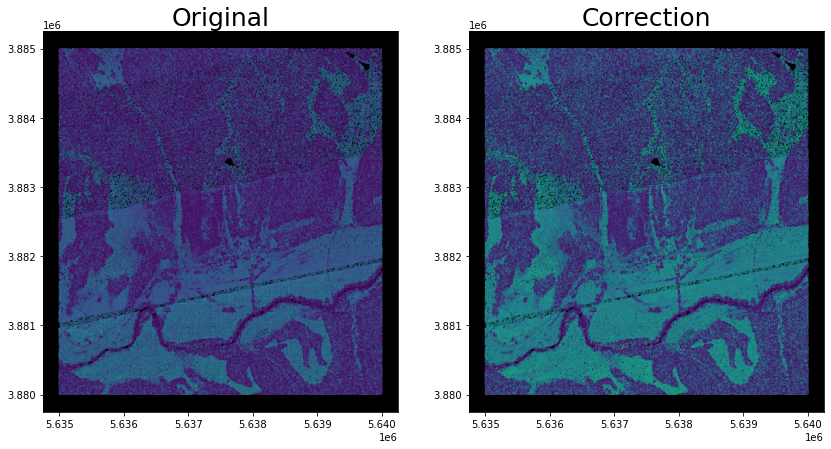

In [22]:
matplotlib.rcParams['figure.figsize'] = [14 , 7]

tile_fixed = data.copy()
target_id = 0
for source_id in range(0, 4):
    if source_id == target_id:
        continue
    print(tile_fixed[np.where(flight_ids==source_id)].shape)
    tile_fixed[np.where(flight_ids==source_id), 5] *= fixes_c[source_id, target_id]

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.scatter(
        tile_fixed[:, 0],
        tile_fixed[:, 1],
        s=0.05, 
        c=data[:, 5], 
        vmin=0, 
        vmax=255)

# ax1.axis('off')
ax1.set_title("Original", fontdict={"fontsize": 25})
ax1.set_facecolor('k')  # sample rate between flights are not unifrom
ax2.scatter(
    tile_fixed[:, 0], 
    tile_fixed[:, 1], 
    s=0.05, 
    c=tile_fixed[:, 5], 
    vmin=0, 
    vmax=255)

# ax2.axis('off')
ax2.set_title(f"Correction", fontdict={"fontsize": 25})
ax2.set_facecolor('k')

plt.show()

# v = pptk.viewer(tile_fixed[:, :3])
# v.attributes(tile_fixed[:, 5], data[:, 5])
    

The linear transformation is able harmonize scans with some efficacy, but there are still some obvious discrepancies between scans. A nonlinear model might be able to do far better.